In [1]:
# librairies système
import os
import sys
import time
import io
from io import StringIO
import logging
from botocore.exceptions import ClientError

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
# imports pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import StandardScaler

# import librairies générales
import pyarrow
from PIL import Image
import numpy as np
import cv2
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt
import boto3

In [3]:
# import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf

# pour éviter des warnings de tf liés à la trace du .predict
tf.compat.v1.disable_eager_execution()

# 1. Initialisation de la session spark

In [4]:
spark = SparkSession.builder.master('local[*]').appName('P8').getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/12 09:25:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
sc

<SparkContext master=local[*] appName=P8>

# 2. Accès à S3
## 2.1 via boto3

In [6]:
# Get resources stored in AWS S3 service
s3_ressources = boto3.resource('s3')

# Print all existing buckets names (only one in this case)
for bucket in s3_ressources.buckets.all():
    print(bucket.name)

p8datahdb


In [7]:
# Affichage des 3 premiers fichiers présents dans le bucket
fruits_bucket = s3_ressources.Bucket('p8datahdb')
for file in fruits_bucket.objects.limit(3):
    label = file.key.split('/')[-2]
    print(label, file.key)

Avocado small_dataset/Avocado/0_100.jpg
Avocado small_dataset/Avocado/1_100.jpg
Carambula small_dataset/Carambula/0_100.jpg


In [8]:
bucket_name = "p8datahdb"
path_img = "s3a://" + bucket_name + "/small_dataset/"
print(path_img)

s3a://p8datahdb/small_dataset/


## 2.2 Via spark directement

In [9]:
# chargement des images disponibles dans le bucket
image_2 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(path_img)
image_2.printSchema()
image_2.show(5)

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)




[Stage 0:>                                                          (0 + 1) / 1]



+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://p8datahdb/s...|2022-07-12 09:21:43|  5667|[FF D8 FF E0 00 1...|
|s3a://p8datahdb/s...|2022-07-12 09:21:43|  5634|[FF D8 FF E0 00 1...|
|s3a://p8datahdb/s...|2022-07-12 09:21:42|  4768|[FF D8 FF E0 00 1...|
|s3a://p8datahdb/s...|2022-07-12 09:21:41|  4756|[FF D8 FF E0 00 1...|
|s3a://p8datahdb/s...|2022-07-12 09:21:41|  4260|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



# 3. Feature extraction
Utilisation du CNN VGG16 pré-entrainé sur ImageNet et sans les couches Fully-Connected pour calculer les features des images 

## 3.1 Chargement du réseau de neurones

In [10]:
model_vgg = VGG16(include_top=False, weights='imagenet', pooling='avg')
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 3.2 Définition des étapes de préprocessing et feature extraction

In [11]:
def bytes_to_array(bytes_str):
    """Transforme une liste de bits en matrice RGB d'une image 100x100px"""
    # arr: Transformation de la suite de bits en matrice 
    arr = np.frombuffer(bytes_str, dtype=np.uint8)
    # arr: Transformation de la matrice au format RGB
    arr = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    arr = arr.astype(np.float32)  # cast en flottant
    return arr


def feature_extraction(model, content_series):
    # conversion du fichier binaire en tableau
    img = content_series.map(bytes_to_array)
    img = np.array(img.to_list(), ndmin=4)
    # preparation des images adaptée au CNN
    img_preproc = preprocess_input(img)
    # calcul des features
    preds = model(img_preproc).numpy()
    # Mise à plat des features
    preds = pd.Series([preds.flatten() for pred in preds])
    return preds


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def UDF_feature_extraction(content_series_iter):
    model = VGG16(include_top=False, weights='imagenet', pooling='avg')
    for content_series in content_series_iter:
        yield feature_extraction(model, content_series)

In [12]:
# calcul des features pour toutes les images disponibles et creation d'un nouveau dataframe spark
# qui regroupe le chemin vers l'image traitée et les features calculées
features_df = image_2.select(col("path"), UDF_feature_extraction("content"))

features_df.show(5)
features_df.printSchema()

+--------------------+-------------------------------+
|                path|UDF_feature_extraction(content)|
+--------------------+-------------------------------+
|s3a://p8datahdb/s...|           [0.0, 0.0, 0.0, 0...|
|s3a://p8datahdb/s...|           [0.0, 0.0, 0.0, 0...|
|s3a://p8datahdb/s...|           [0.0, 0.0, 0.0, 0...|
|s3a://p8datahdb/s...|           [10.527054, 0.0, ...|
|s3a://p8datahdb/s...|           [10.527054, 0.0, ...|
+--------------------+-------------------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- UDF_feature_extraction(content): array (nullable = true)
 |    |-- element: float (containsNull = true)



# 4. Réduction de dimension
La dimension des features créées est dépendante du CNN choisit. Afin de vérifier cette dimension, la featurisation est appliquées sur une image

La feature extraction génère 512 features par image


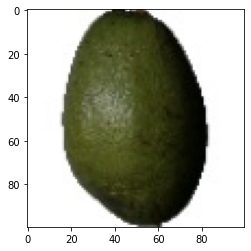

In [13]:
# test_file: Fichier de l'image d'exemple
test_file = 'small_dataset/Avocado/0_100.jpg'

# image: Contenu du fichier de l'image d'exemple
s3_client = boto3.client("s3")
load = s3_client.get_object(Bucket=bucket_name, Key=test_file)
image = imread(load['Body'], format='jpg')
plt.imshow(image)
# preprocessing
image = img_to_array(image)
# redimensionnement des données pour le modèle
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preparation des imagespour le modèle VGG
img_preproc = preprocess_input(image)
# extraction des features
img_features = model_vgg.predict(img_preproc)

print("La feature extraction génère {} features par image".format(img_features.shape[1]))

In [14]:
# conversion du tableau de features en vecteur pour le calcul de l'ACP
array_to_vector_UDF = udf(lambda arr: Vectors.dense(arr), VectorUDT())
features_df_w_vectors = features_df.select(
    features_df["path"],
    array_to_vector_UDF(features_df["UDF_feature_extraction(content)"]).alias("feature_extraction_vector")
)
features_df_w_vectors.show(5)
features_df_w_vectors.printSchema()

+--------------------+-------------------------+
|                path|feature_extraction_vector|
+--------------------+-------------------------+
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|
|s3a://p8datahdb/s...|     [10.5270538330078...|
|s3a://p8datahdb/s...|     [10.5270538330078...|
+--------------------+-------------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- feature_extraction_vector: vector (nullable = true)



In [15]:
# calcul de l'ACP
# k=5 est choisi arbitrairement
pca = PCA(k=5, inputCol="feature_extraction_vector", outputCol="feature_pca")
model_pca = pca.fit(features_df_w_vectors)

In [16]:
# transformation des données
transformed_feature = model_pca.transform(features_df_w_vectors)
transformed_feature.show(5)
transformed_feature.printSchema()

+--------------------+-------------------------+--------------------+
|                path|feature_extraction_vector|         feature_pca|
+--------------------+-------------------------+--------------------+
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|[281.527269080335...|
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|[281.527269080335...|
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|[281.527269080335...|
|s3a://p8datahdb/s...|     [10.5270538330078...|[-63.207901983217...|
|s3a://p8datahdb/s...|     [10.5270538330078...|[-63.207901983217...|
+--------------------+-------------------------+--------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- feature_extraction_vector: vector (nullable = true)
 |-- feature_pca: vector (nullable = true)




[Stage 13:>                                                         (0 + 1) / 1]



In [17]:
# Transformation des vecteurs en Array
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

In [18]:
df_img = transformed_feature.withColumn('pca_array', vector_to_array_udf('feature_pca'))

In [19]:
df_img.show(5)
df_img.printSchema()

+--------------------+-------------------------+--------------------+--------------------+
|                path|feature_extraction_vector|         feature_pca|           pca_array|
+--------------------+-------------------------+--------------------+--------------------+
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|[281.527269080335...|[281.52728, 15.29...|
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|[281.527269080335...|[281.52728, 15.29...|
|s3a://p8datahdb/s...|     [0.0,0.0,0.0,0.0,...|[281.527269080335...|[281.52728, 15.29...|
|s3a://p8datahdb/s...|     [10.5270538330078...|[-63.207901983217...|[-63.2079, 15.298...|
|s3a://p8datahdb/s...|     [10.5270538330078...|[-63.207901983217...|[-63.2079, 15.298...|
+--------------------+-------------------------+--------------------+--------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- feature_extraction_vector: vector (nullable = true)
 |-- feature_pca: vector (nullable = true)
 |-- pca_array:

In [20]:
# Transformation du dataframe spark en dataframe pandas
results_df = df_img.toPandas()
results_df

,path,feature_extraction_vector,feature_pca,pca_array
0,s3a://p8datahdb/small_dataset/Strawberry/1_100...,"[0.0, 0.0, 0.0, 0.0, 0.4779968857765198, 0.243...","[281.52726908033566, 15.298253900730908, 1.498...","[281.52728271484375, 15.298254013061523, 1.498..."
1,s3a://p8datahdb/small_dataset/Strawberry/0_100...,"[0.0, 0.0, 0.0, 0.0, 0.4779968857765198, 0.243...","[281.52726908033566, 15.298253900730908, 1.498...","[281.52728271484375, 15.298254013061523, 1.498..."
2,s3a://p8datahdb/small_dataset/Carambula/1_100.jpg,"[0.0, 0.0, 0.0, 0.0, 0.4779968857765198, 0.243...","[281.52726908033566, 15.298253900730908, 1.498...","[281.52728271484375, 15.298254013061523, 1.498..."
3,s3a://p8datahdb/small_dataset/Carambula/0_100.jpg,"[10.527053833007812, 0.0, 2.137017011642456, 0...","[-63.207901983217035, 15.29825390073049, 1.498...","[-63.20790100097656, 15.298254013061523, 1.498..."
4,s3a://p8datahdb/small_dataset/Avocado/1_100.jpg,"[10.527053833007812, 0.0, 2.137017011642456, 0...","[-63.207901983217035, 15.29825390073049, 1.498...","[-63.20790100097656, 15.298254013061523, 1.498..."
5,s3a://p8datahdb/small_dataset/Avocado/0_100.jpg,"[10.527053833007812, 0.0, 2.137017011642456, 0...","[-63.207901983217035, 15.29825390073049, 1.498...","[-63.20790100097656, 15.298254013061523, 1.498..."


# Stockage des résultats sur S3

In [21]:
def create_bucket(bucket_name, region="eu-west-3"):
    """Creation d'un bucket dans la région spécifiée

    Si la région n'est pas précisée, le bucket sera créé dans la région 
    par défaut (us-east-1).

    :param bucket_name: String. Bucket à créer
    :param region: String. Région dans laquelle créer le bucket
    :return: True si le bucket est créé, False sinon
    """

    # création du bucket
    try:
        if region is None:
            s3_client = boto3.client('s3')
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name,
                                    CreateBucketConfiguration=location)
        # configuration du bucket pour qu'il soit non accessible au public
        response_public = s3_client.put_public_access_block(Bucket=bucket_name,
                                                            PublicAccessBlockConfiguration={
                                                                'BlockPublicAcls': True,
                                                                'IgnorePublicAcls': True,
                                                                'BlockPublicPolicy': True,
                                                                'RestrictPublicBuckets': True
                                                            }
                                                           )
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [22]:
#verifie si le bucket des données traitées existe déjà, si ce n'est pas le cas => création du bucket
bucket_donnees_traitees = 'p8donneestraitees'
besoin_creation_bucket = True

for bucket in s3_ressources.buckets.all():
    if bucket.name == bucket_donnees_traitees:
        besoin_creation_bucket = False
if besoin_creation_bucket:
    print('Création du bucket {}'.format(bucket_donnees_traitees))
    create_bucket(bucket_donnees_traitees)
else:
    print('Bucket déjà existant')

Création du bucket p8donneestraitees


In [23]:
# Stockage des résultats sur le bucket S3
csv_buffer = StringIO()
results_df.to_csv(csv_buffer)
response = s3_client.put_object(
    Body=csv_buffer.getvalue(),
    Bucket=bucket_donnees_traitees,
    Key='Feature_extraction/results.csv')

In [24]:
# Déplacement des images traitées depuis le bucket initial vers le bucket p8donneestraitees
bucket_source = s3_ressources.Bucket('p8datahdb')
bucket_destination = s3_ressources.Bucket('p8donneestraitees')

for file in bucket_source.objects.all():
    source_copie = {
        'Bucket': 'p8datahdb',
        'Key': file.key
    }
    bucket_destination.copy(source_copie, file.key)
    file.delete()
    print(file.key, 'déplacé vers p8donneestraitees')

small_dataset/Avocado/0_100.jpg déplacé vers p8donneestraitees
small_dataset/Avocado/1_100.jpg déplacé vers p8donneestraitees
small_dataset/Carambula/0_100.jpg déplacé vers p8donneestraitees
small_dataset/Carambula/1_100.jpg déplacé vers p8donneestraitees
small_dataset/Strawberry/0_100.jpg déplacé vers p8donneestraitees
small_dataset/Strawberry/1_100.jpg déplacé vers p8donneestraitees


In [25]:
sc.stop()